<a href="https://colab.research.google.com/github/Zafar-Lab/scDREAMER/blob/main/2109_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" # difference between gpu '0' and '1'

"""
# for reproducibility with server...

os.environ["PYTHONHASHSEED"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # setting "true"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
"""

import numpy as np
import tensorflow as tf2
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import scipy.io
from sklearn.decomposition import PCA
import pdb

import pandas as pd
import scanpy as sc


import scipy.sparse
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import stats 
from scipy import * 
import datetime 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

os.getpid()


2023-07-03 20:44:16.963636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 20:44:17.620244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


10407

In [2]:
#tf.enable_eager_execution()
np.random.seed(0)
#tf.set_random_seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)
#tf.keras.utils.set_random_seed(0)

In [3]:
import warnings
warnings.filterwarnings('ignore')
"""
!pip install -U scipy==1.5.0
!pip install scanpy==1.8.2
!pip install -U scikit-learn
"""

'\n!pip install -U scipy==1.5.0\n!pip install scanpy==1.8.2\n!pip install -U scikit-learn\n'

Building model

In [4]:

data_path = "/home/ajita/Documents/data_integration/Pancreas/Pancreas.h5ad"


In [5]:
name = "Pancreas"

batch_key_dic = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch"
                 
                }
cell_type_key_dic = {'Immune_Human' : 'final_annotation', # 16
                 'Lung' : 'cell_type', # 
                 'Pancreas' : 'celltype', #
                 'Human_Mouse' : "celltype", #
                 "Human_Retina":"Subcluster" #
                    }    
our_method_emb_dic = {'Immune_Human' : 'Immune_Human_case2_latent_matrix_c_300',
                 'Lung' : 'Lung_case2_latent_matrix_c_300',
                 'Pancreas' : 'Pancreas_case2_latent_matrix_c_250',
                 'Human_Retina': "retina_case2_latent_matrix_c_300"    
                }  

2023-07-03 20:44:20.350826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


came in load_gene
updated hvg
updated hvg
Data set to work on:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.64225215 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.4693582  0.         0.40642774 ... 0.1222083  0.         0.        ]
 [0.25236475 0.         0.         ... 0.         0.         0.        ]
 [0.22984092 0.         0.         ... 0.         0.         0.35111868]]
(15327, 2000)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(15327, 9)
encoder input shape  Tensor("concat:0", shape=(?, 2009), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 19), dtype=float32)
KL 

2023-07-03 20:44:56.522918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 491.4684, d_loss: -0.0102
latent_matrix shape (16382, 10)
(16382,)


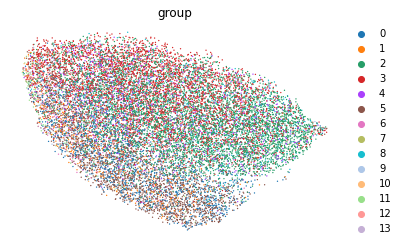

None


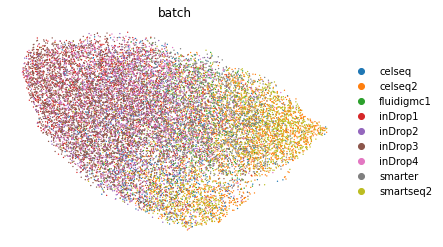

None
Computing NMI ...
Done !
NMI = 0.1477234710671345
Epoch : [1] ,  a_loss = 541.4578, d_loss: -0.0036
Epoch : [2] ,  a_loss = 604.6948, d_loss: -0.0022
Epoch : [3] ,  a_loss = 407.9263, d_loss: -0.0088
Epoch : [4] ,  a_loss = 507.0458, d_loss: -0.0104
Epoch : [5] ,  a_loss = 621.7297, d_loss: -0.0013
Epoch : [6] ,  a_loss = 601.0350, d_loss: -0.1228
Epoch : [7] ,  a_loss = 466.7234, d_loss: -0.1103
Epoch : [8] ,  a_loss = 367.9683, d_loss: -0.0527
Epoch : [9] ,  a_loss = 382.5525, d_loss: -0.0710
Epoch : [10] ,  a_loss = 387.4597, d_loss: -0.1114
Epoch : [11] ,  a_loss = 417.9584, d_loss: -0.1208
Epoch : [12] ,  a_loss = 669.7751, d_loss: -0.0022
Epoch : [13] ,  a_loss = 599.3467, d_loss: -0.0160
Epoch : [14] ,  a_loss = 666.7653, d_loss: -0.0029
Epoch : [15] ,  a_loss = 572.7554, d_loss: -0.0423
Epoch : [16] ,  a_loss = 406.2842, d_loss: -0.0310


In [ ]:

#import src.model as model
#import src.model_wo_BC as model
#import src.model_wo_Dis as model

#import src_shuffle.model as model

import src_shuffle_alpha_delta_exp.model_heldout_experiment as model

run_config = tf.ConfigProto()

run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    dreamer = model.scDREAMER(
        sess,
        epoch = 300,
        dataset_name = data_path,
        batch = batch_key_dic[name],
        cell_type = cell_type_key_dic[name],
        name = name
        )

    dreamer.train_cluster()

